In [1]:
## PACKAGES
from pyDeepInsight import ImageTransformer, CAMFeatureSelector

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

from IPython.display import display, clear_output

/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/uma

In [2]:
##LOAD DATA
expr_file = r"./data/Survival_TCGA_VS_Desmd/filtered_desmd_average.csv"
expr = pd.read_csv(expr_file, encoding='utf-8', engine='python')
expr=expr.transpose()
expr.columns=expr.iloc[0]
X = expr.iloc[1:,1:-1].values
X=X.astype(float)
Y = expr.iloc[1:,-1].values
genes = expr.iloc[:,:-1].columns.to_numpy()


In [3]:
genes

array(['DDR1', 'RFC2', 'HSPA6', ..., 'SNHG17', 'LOC100505915', 'NPEPL1'],
      dtype=object)

In [4]:
random_state=1515
X_train, X_test, y_train, y_test = train_test_split(
X, Y, test_size=0.2, shuffle=True, stratify=Y)

Remove low variance data. In this case the bottom 30%.

In [5]:
var_filter = X.var(0) >= np.percentile(X.var(0), 30., method='nearest')

In [6]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[:, var_filter])
X_test_norm = mms.transform(X_test[:, var_filter])


Encode the classes

In [7]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

In [8]:
num_classes

2

## DeepInsight Image Transformation
Convert data to image format using DeepInsight

In [168]:
reducer = umap.UMAP(
    n_neighbors=40,
    n_components=2,
    min_dist=0.8,
    metric='manhattan',
    n_jobs=-1,
    random_state=42
)

pixel_size = (224,224)
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

(8810, 2)


/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/pyDeepInsight/image_transformer.py:271: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


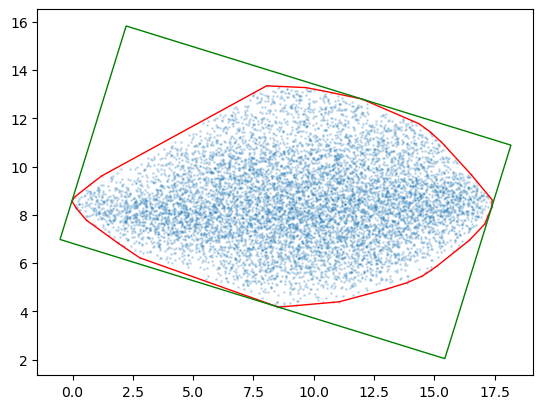

In [169]:
it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

## CNN Image Classification
Train ResNet50 CNN

In [170]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [171]:
net = timm.create_model('resnet50', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

In [172]:
batch_size=10
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [173]:
criterion = nn.CrossEntropyLoss()
##optimizer = optim.SGD(net.parameters(),lr=1e-02,momentum=2,)
optimizer = optim.Adam(net.parameters(),lr=0.0001)

In [174]:
net.train()
for epoch in range(100):
    for i, (inputs, labels) in enumerate(trainloader):
        clear_output(wait=True)
        display(f"Epoch {epoch:03d}, batch {i:03d}")
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

'Epoch 099, batch 012'

In [167]:
test_predicted = np.empty(0)
test_true = np.empty(0)
net=net.to(device)
net.eval()


with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())

net=net.to(torch.device('cpu'))
with torch.no_grad():
    y_hat = net(X_train_tensor.cpu())
train_predicted = torch.max(y_hat, 1)[1]

print(f"The train accuracy was {accuracy_score(train_predicted, y_train_enc):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")


The train accuracy was 1.000
The test accuracy was 0.667


## SqueezeNet

In [17]:
import torchvision
device1 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
model_sq = torchvision.models.squeezenet1_1(weights='DEFAULT')
model_sq.classifier.append(nn.Flatten())
_ = model_sq.classifier.append(nn.Linear(1000, num_classes))

##transforming image to tensor
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [19]:
X_train_tensor_sq = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor_sq = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor_sq = torch.stack([preprocess(img) for img in X_test_img]).float()
y_test_tensor_sq = torch.from_numpy(le.transform(y_test))

Generate pyTorch datasets and dataloaders for training and testing sets.

In [20]:
batch_size = 10

trainset = TensorDataset(X_train_tensor_sq, y_train_tensor_sq)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor_sq, y_test_tensor_sq)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Specify loss function and optimization algorithm

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model_sq.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

## DeepFeature: CAM-based Feature Selection

In [22]:
model_sq.train()
model_sq.to(device1)
for epoch in range(120):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device1)
        labels = labels.to(device1)

        outputs = model_sq(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor_sq) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor_sq) * batch_size:.3f}')

[0] loss: 0.848
[20] loss: 0.654
[40] loss: 0.678
[60] loss: 0.654
[80] loss: 0.531
[100] loss: 0.554
[119] loss: 0.693


In [23]:
model_sq.to('cpu')
model_sq = model_sq.eval()

with torch.no_grad():
    y_hat = model_sq(X_train_tensor_sq)
train_predicted = torch.max(y_hat, 1)[1]


with torch.no_grad():
    y_hat = model_sq(X_test_tensor_sq)
test_predicted = torch.max(y_hat, 1)[1]

print(f"The train accuracy was {accuracy_score(train_predicted, y_train_tensor_sq):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, y_test_tensor_sq):.3f}")

The train accuracy was 0.612
The test accuracy was 0.606


In [24]:
cm_method='GradCAM'
camfs = CAMFeatureSelector(
    model=net,
    it=it,
    cam_method=cm_method
)

In [25]:
fl_method = "mean"
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)

In [26]:
fs_threshold = 0.6
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)

In [27]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt

def cam_image(X, y, cam, fs, threshold):
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(8, 4),
                            constrained_layout=True)
    for cat in np.unique(y):
        row = cat // 4
        col = cat % 4
        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        cam_cat = cam[cat].copy()
        cam_cat[cam_cat <= threshold] = 0
        visualization = show_cam_on_image(
            np.transpose(X_cat, (1,2,0)),
            cam_cat,
            use_rgb=True
        )
        _ = axs[row, col].imshow(visualization)
        axs[row, col].text(0,0,le_mapping[cat],c="white",ha="left",va="top",weight="bold",size="x-large")
        axs[row, col].text(227,227,f"{fs[cat].shape[0]} genes",c="white",ha="right",va="bottom",weight="bold",size="large")
        axs[row, col].axis('off')
    return fig, axs

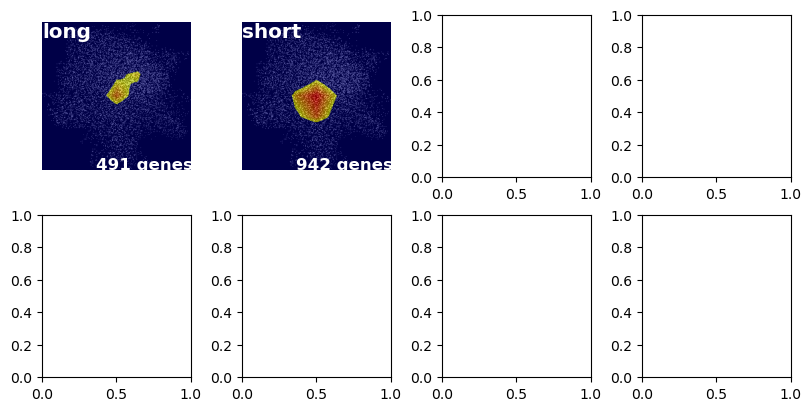

In [28]:
_ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)

In [29]:
for cat, idx in feat_idx.items():
    feature_names = genes[idx]
    print(f"{idx.shape[0]:5} features selected for {le_mapping[cat]:4}: {', '.join(feature_names[1:10])}...")

  491 features selected for long: HSPA6, PAX8, GUCA1A, UBA7, CCL5, EPHB3, ESRRA, MMP14, TRADD...
  942 features selected for short: GUCA1A, THRA, CCL5, CYP2E1, MMP14, TRADD, DTX2P1-UPK3BP1-PMS2P11, BAD, CAPNS1...
